# Ótimização de Custos de plano de saúde

## Contextualização e objetivos

Uma empresa do ramo alimentício tem mais de 20 mil colaboradores em todo o Brasil. Com o passar dos anos a empresa percebeu um aumento no custo do plano de saúde com seus colaboradores. Como forma de entender esse comportamento, a gerência de Benefícios e Bem Estar da Diretoria de Pessoas conduziu uma pesquisa interna com um grupo de 1.338 colaboradores sorteados aleatoriamente.

 

A gerência acredita que fatores como fumo e obesidade podem estar relacionados com o maior uso do plano de saúde, o que acaba elevando os custos. Portanto, os colaboradores da pesquisa responderam características pessoais como o Índice de Massa Corpórea (IMC), Qte de Filhos e se fazem uso de cigarros.

 

Com base nessas informações, temos como objetivos:

 

1. Descobrir quais fatores estão mais relacionados com o Custo do Plano de Saúde na empresa;

2. Desenvolver um modelo que estime o custo de saúde dos próximos 3 meses.

3. Validar o modelo com técnicas de Out of Samples, Out of Time e Validação cruzada;
 


A base possui as seguintes variaveis:

- Idade - Idade do colaborador (Quantitativa)
- Sexo - Sexo do colaborador (Qualitativa)
- IMC - Índice de Massa Corporal do colaborador (Quantitativa)
- Qte_Filhos - 	Qte de filhos que o colaborador tem (Quantitativa)
- Fumante - Flag se o colaborador é fumante ou não fumante (Qualitativa)
- Região - Região do Brasil onde o colaborador mora (Qualitativa)
- Custo_Saude - Custo de Plano de Saúde que esse colaborador tem (Quantitativa)

Vamos começar conhecendo e explorando os dados que temos em mãos.

In [30]:
# manipulação de dados
import pandas as pd
import numpy as np

# graficos
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker

# modelos
from sklearn import linear_model

# metricas
from sklearn.metrics import mean_squared_error,r2_score

# particionamento
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings("ignore")

## Análise descritiva

In [31]:
df = pd.read_excel('base_custos_saude.xlsx', sheet_name = 'base')
df.head()

,DtRef,Idade,Sexo,IMC,Qte_Filhos,Fumante,Regiao,Custo_Saude
0,202101,25,Masculino,26.220,0,Não,Nordeste,272.132080
1,202101,23,Masculino,17.385,1,Não,Norte,277.519215
2,202101,41,Masculino,21.780,1,Não,Sudeste,627.247720
3,202101,38,Masculino,37.050,1,Não,Nordeste,607.967150
4,202101,60,Feminino,24.530,0,Não,Sudeste,1262.989670


Dentro da amostra coletada podemos observar:

- Há colaboradores entre 18 a 64 anos. Sendo que metade possui menos que 39 anos;
- Apenas cerca de 20% dos colaboradores estão dentro do peso considerado normal, enquanto os outros 80% apresentam algum nível de desvio. Desses 80%, 29% estão classificados com sobrepeso, e o restante é afetado por diferentes graus de obesidade;  
- Há colaboradores que tem 5 filhos, assim como há colaboradores que não tem filhos;
- O custo médio do plano de saúde é de `R$ 1327,04`. Metade dos colaboradores custam menos que `R$ 938,200`, porém há colaborados custando `R$ 6377,04`.

In [32]:
df.describe()

,DtRef,Idade,IMC,Qte_Filhos,Custo_Saude
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,202106.503737,39.207025,30.663397,1.094918,1327.042227
std,3.428562,14.049960,6.098187,1.205493,1211.001124
min,202101.000000,18.000000,15.960000,0.000000,112.187390
25%,202104.000000,27.000000,26.296250,0.000000,474.028715
50%,202106.000000,39.000000,30.400000,1.000000,938.203300
75%,202109.000000,51.000000,34.693750,2.000000,1663.991252
max,202112.000000,64.000000,53.130000,5.000000,6377.042801


## Análise exploratória



O histograma é uma ferramenta poderosa para visualizar padrões, tendências e variações em um conjunto de dados, permitindo uma compreensão rápida
             e intuitiva da distribuição dos valores. O histograma abaixo mostra como está a distribuição do custo do plano de saúde dos colaboradores, no
            gráfico podemos observar que grande parte dos colaboradores tem um custo abaixo dos `R$ 1000,00`, e estão bem distruidos até os `R$ 2000,00` com alguns
        poucos acima dos R$ 4000,00.

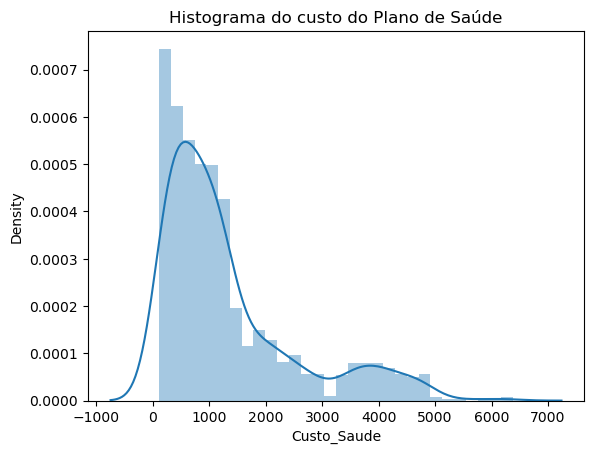

In [33]:
sns.distplot(df['Custo_Saude']);
plt.title('Histograma do custo do Plano de Saúde')

plt.savefig("graficos/hist_custo_saude.jpeg")

In [34]:
df1 = df.copy()

# Definir os limites dos grupos de idades
limites = [18, 28, 39, 50, 65]

# Definir os rótulos dos grupos de idades
rotulos = ['18 - 28', '29 - 39', '40 - 50', '51+']

# Criar uma nova coluna no dataframe com os grupos de idades
df1['Idade_Cat'] = pd.cut(df1['Idade'], bins=limites, labels=rotulos, right=False)

idade_cat = df1.groupby('Idade_Cat')['Custo_Saude'].sum().reset_index().round(2)
idade_cat = idade_cat.rename(columns = {'Custo_Saude': 'Frequencia'})
idade_cat['Frequencia Relativa'] = (idade_cat['Frequencia']/idade_cat['Frequencia'].sum() * 100).round(2)  
idade_cat['Frequencia Acumulada'] = idade_cat['Frequencia Relativa'].cumsum()

idade_cat

,Idade_Cat,Frequencia,Frequencia Relativa,Frequencia Acumulada
0,18 - 28,329354.56,18.55,18.55
1,29 - 39,325796.30,18.35,36.90
2,40 - 50,431183.39,24.28,61.18
3,51+,689248.25,38.82,100.00


Como observado na análise descritiva, aproximadamente metade dos colaboradores desta amostra possui menos de 39 anos, o que poderia sugerir que a despesa do plano de saúde estaria igualmente distribuída nessa faixa etária. Entretanto, ao analisar a linha vermelha no gráfico abaixo, que indica o percentual acumulado de cada faixa etária, percebe-se que os grupos com menos de 39 anos gastam apenas 37% do total de recursos destinados ao plano de saúde. Isso indica uma distribuição desigual de custos, com outras faixas etárias contribuindo de forma mais significativa para o montante global. Essa análise destaca a importância de considerar diferentes grupos etários ao planejar os gastos do plano de saúde e pode oferecer insights para futuras estratégias de otimização e alocação de recursos.

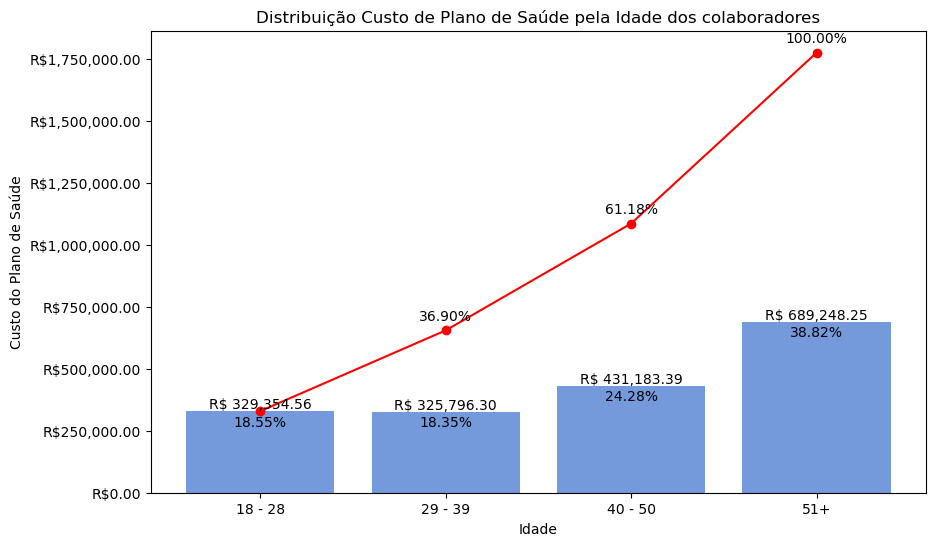

In [35]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Idade_Cat', y='Frequencia', data=idade_cat, color='cornflowerblue')

# Adicionar 'R$' nos valores do eixo y
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter('R${x:,.2f}'))

# Add the percentages as text on top of the bars
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 10000, f'R$ {height:,.2f}', ha='center')

# Add the percentage labels above the bars
for index, row in idade_cat.iterrows():
    plt.text(index, row['Frequencia'] - 60000, f'{row["Frequencia Relativa"]:.2f}%', ha='center')
    
    
# Adicionar linha de porcentagem acumulada com rótulos

plt.plot(ax.get_xticks(), idade_cat['Frequencia'].cumsum(), marker='o', color='red')
for index, value in enumerate(idade_cat['Frequencia'].cumsum()[1:]):
    plt.text(index+1, value + 40000, f'{idade_cat["Frequencia Acumulada"][index+1]:.2f}%', ha='center', color='black')


plt.xlabel('Idade')
plt.ylabel('Custo do Plano de Saúde')
plt.title('Distribuição Custo de Plano de Saúde pela Idade dos colaboradores')
#plt.grid(True)
#plt.xticks(rotation=45)

plt.savefig("graficos/custo_saudexidade.jpeg")
plt.show()


In [36]:
df2 = df.copy()
# Definir os limites dos grupos de idades
limites = [0,17, 18.49, 24.99, 29.99, 34.99, 39.9,  float('inf')]

# Definir os rótulos dos grupos de idades
rotulos = ['Muito abaixo do peso','Abaixo do peso', 'Peso normal', 'Sobrepeso', 'Obesidade grau I', 'Obesidade grau II', 'Obesidade grau III']

# Criar uma nova coluna no dataframe com os grupos de idades
df2['IMC_cat'] = pd.cut(df2['IMC'], bins=limites, labels=rotulos, right=False)

imc_cat = df2.groupby('IMC_cat')['Custo_Saude'].agg('sum').reset_index().round(2)
imc_cat = imc_cat.rename(columns = {'Custo_Saude': 'Frequencia'})
imc_cat['Frequencia Relativa'] = (imc_cat['Frequencia']/imc_cat['Frequencia'].sum() * 100).round(2)  
imc_cat['Frequencia Acumulada'] = imc_cat['Frequencia Relativa'].cumsum()

imc_cat_count = df2.groupby('IMC_cat')['Custo_Saude'].agg('count').reset_index().round(2)
imc_cat_count = imc_cat_count.rename(columns = {'Custo_Saude': 'Frequencia'})
imc_cat_count['Frequencia Relativa'] = (imc_cat_count['Frequencia']/imc_cat_count['Frequencia'].sum() * 100).round(2)  
imc_cat_count['Frequencia Acumulada'] = imc_cat_count['Frequencia Relativa'].cumsum() 
imc_cat_count

,IMC_cat,Frequencia,Frequencia Relativa,Frequencia Acumulada
0,Muito abaixo do peso,3,0.22,0.22
1,Abaixo do peso,17,1.27,1.49
2,Peso normal,225,16.82,18.31
3,Sobrepeso,386,28.85,47.16
4,Obesidade grau I,391,29.22,76.38
5,Obesidade grau II,222,16.59,92.97
6,Obesidade grau III,94,7.03,100.00


In [37]:
imc_cat

,IMC_cat,Frequencia,Frequencia Relativa,Frequencia Acumulada
0,Muito abaixo do peso,1150.28,0.06,0.06
1,Abaixo do peso,16554.12,0.93,0.99
2,Peso normal,234210.10,13.19,14.18
3,Sobrepeso,424117.88,23.89,38.07
4,Obesidade grau I,563809.29,31.75,69.82
5,Obesidade grau II,375914.73,21.17,90.99
6,Obesidade grau III,159826.09,9.00,99.99


Como visto na análise descritiva anteriormente, cerca de 80% dos colaboradores estão acima do peso normal, é normal pensar que eles custariam mais para o plano de saúde. Como observado no gráfico abaixo eles custeam cerca de 85% do valor total, sendo que os colaboradores classificados com "Obesidade de grau I" são os mais custosos (31,75% da verba) entre eles.

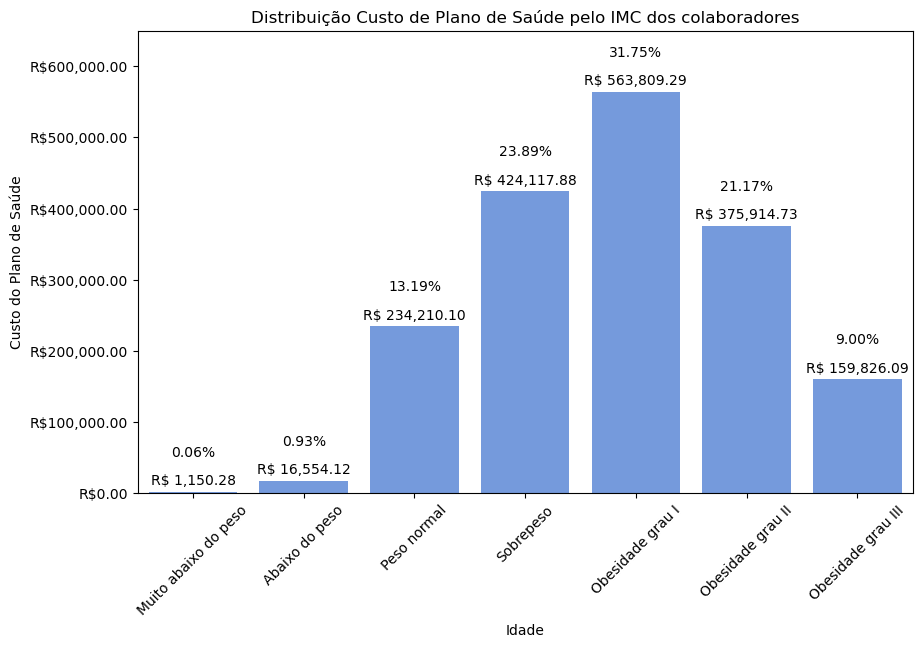

In [38]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='IMC_cat', y='Frequencia', data=imc_cat, color='cornflowerblue')

# Adicionar 'R$' nos valores do eixo y
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter('R${x:,.2f}'))

# Add the percentages as text on top of the bars
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 10000, f'R$ {height:,.2f}', ha='center')

# Add the percentage labels above the bars
for index, row in imc_cat.iterrows():
    plt.text(index, row['Frequencia'] + 50000, f'{row["Frequencia Relativa"]:.2f}%', ha='center')
    
    



plt.xlabel('Idade')
plt.ylabel('Custo do Plano de Saúde')
plt.ylim(0, 650000)
plt.title('Distribuição Custo de Plano de Saúde pelo IMC dos colaboradores')
#plt.grid(True)
plt.xticks(rotation=45)

plt.savefig("graficos/custo_saudeximc.jpeg")
plt.show()


O gráfico de boxplot é uma representação visual compacta e informativa que mostra a distribuição estatística de um conjunto de dados numéricos. Ele exibe a mediana, os quartis, a presença de outliers e a dispersão dos dados, permitindo uma rápida compreensão da distribuição e identificação de informações importantes, tornando-se uma ferramenta valiosa na análise exploratória de dados.

Abaixo temos alguns gráficos de boxplots relacionando para visualizar como está distribuida o Custo de Plano de Saúde com os fatores categoricos da base de dados ( Sexo do colaborador, Quantidade de filhos, Fumante e Região em que o colaborador vive)

No gráfico 1 comparando os custos do plano de saúde entre homens e mulheres. Vemos que as caixas estão no mesmo nível, indicando que não tem diferença no custo do plano, além de terem a mesma mediana próximo de `R$ 1000,00`, como visto na analise descritiva anteriormente.

No gráfico 2 estamos comparando o custo do plano de saúde com a quantidade de filhos dos colaboradores. Nele podemos observar que os colaboradores que possuem 5 filhos tem um custo mais concentrado em torno dos `R$ 1000,00`, contendo apenas um outlier que mal chega a custar `R$ 2000,00` para a empresa. Já colaboradores com menos que 5 filhos possam variar muito e chegar a custar `R$ 4000,00`, sem contar com os outliers chegando a mair de `R$ 6000,00`.

**No gráfico 3 observamos como os colaboradores fumantes custam mais para o plano de saúde do que para os colaboradores que não são fumantes.**

No gráfico 4 não vemos nenhuma região que custe mais para o plano de saúde.

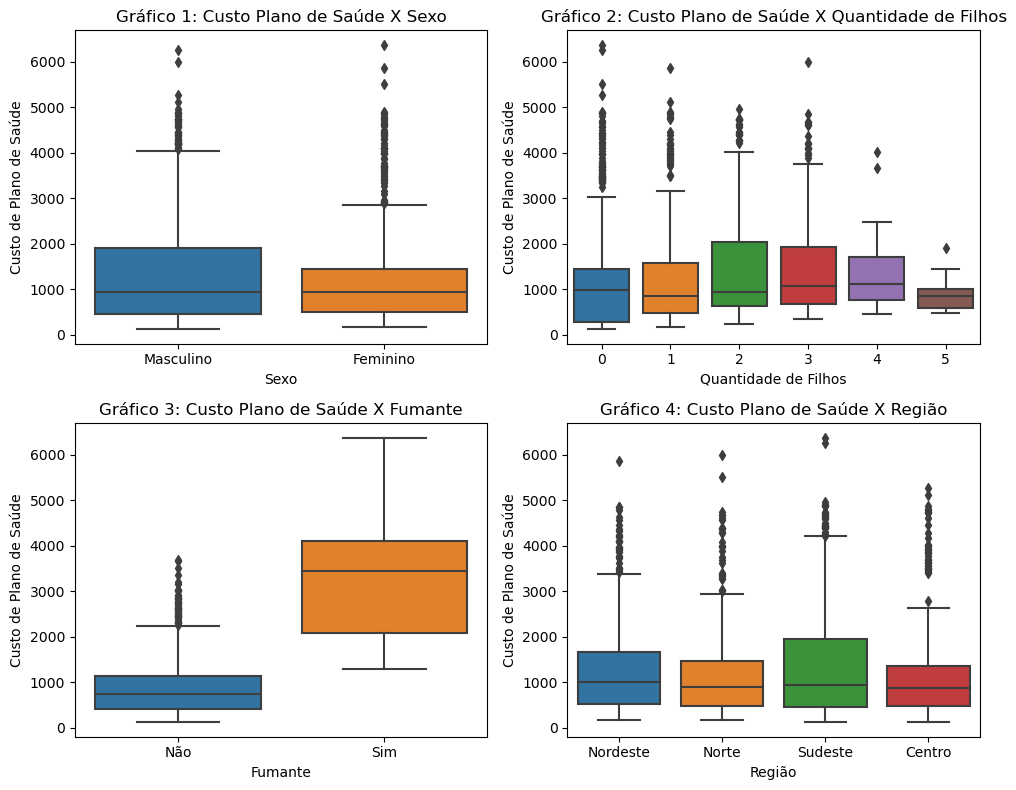

In [39]:
custo = df['Custo_Saude']
variaveis_quali = df[['Sexo', 'Qte_Filhos', 'Fumante', 'Regiao']]

data1 = df[['Custo_Saude', 'Sexo']]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Plota o primeiro boxplot na posição (0,0)
sns.boxplot(y = df['Custo_Saude'], x=df['Sexo'], ax=axes[0,0])
axes[0, 0].set_ylabel('Custo de Plano de Saúde')
axes[0, 0].set_xlabel('Sexo')
axes[0, 0].set_title('Gráfico 1: Custo Plano de Saúde X Sexo')

# Plota o segundo boxplot na posição (0,1)
sns.boxplot(y = df['Custo_Saude'], x=df['Qte_Filhos'], ax=axes[0,1])
axes[0, 1].set_ylabel('Custo de Plano de Saúde')
axes[0, 1].set_xlabel('Quantidade de Filhos')
axes[0, 1].set_title('Gráfico 2: Custo Plano de Saúde X Quantidade de Filhos')

# Plota o terceiro boxplot na posição (1,0)
sns.boxplot(y=df['Custo_Saude'], x=df['Fumante'], ax=axes[1, 0])
axes[1, 0].set_ylabel('Custo de Plano de Saúde')
axes[1, 0].set_xlabel('Fumante')
axes[1, 0].set_title('Gráfico 3: Custo Plano de Saúde X Fumante')

# Plota o quarto boxplot na posição (1,1)
sns.boxplot(y=df['Custo_Saude'], x=df['Regiao'], ax=axes[1, 1])
axes[1, 1].set_ylabel('Custo de Plano de Saúde')
axes[1, 1].set_xlabel('Região')
axes[1, 1].set_title('Gráfico 4: Custo Plano de Saúde X Região')

# Ajusta o layout para evitar sobreposição de títulos e rótulos
plt.tight_layout()

# Mostra a figura com os boxplots
plt.savefig("graficos/custo_saudexboxplot.jpeg")
plt.show()

## Correlação com o custo do plano de saúde

Para correlacionar as variáveis numericas utilizaremos a correlação de Pearson, uma medida estatística que avalia a relação linear entre duas variáveis quantitativas. O coeficiente de correlação varia entre -1 e 1, onde -1 indica uma correlação negativa perfeita, 1 indica uma correlação positiva perfeita e 0 indica ausência de correlação. É amplamente utilizado em pesquisas científicas e análises estatísticas para examinar a associação entre variáveis contínuas. No entanto, a correlação não implica causalidade, e sua interpretação deve considerar a linearidade das relações e a sensibilidade a outliers



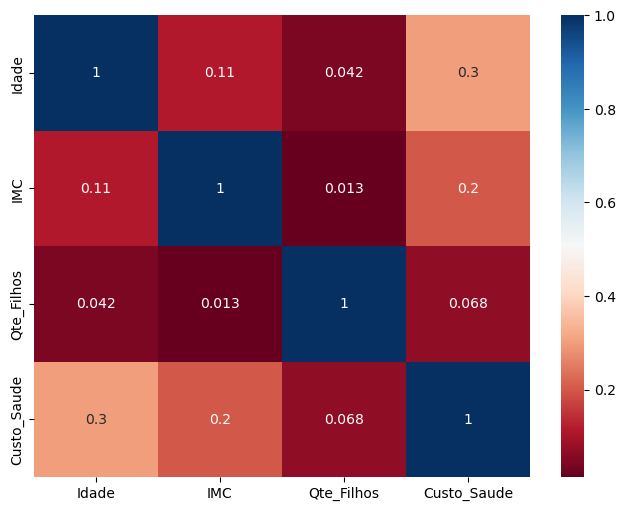

In [40]:
plt.figure(figsize = (8,6))
sns.heatmap(df.drop('DtRef', axis=1).corr(),cmap='RdBu', annot=True);

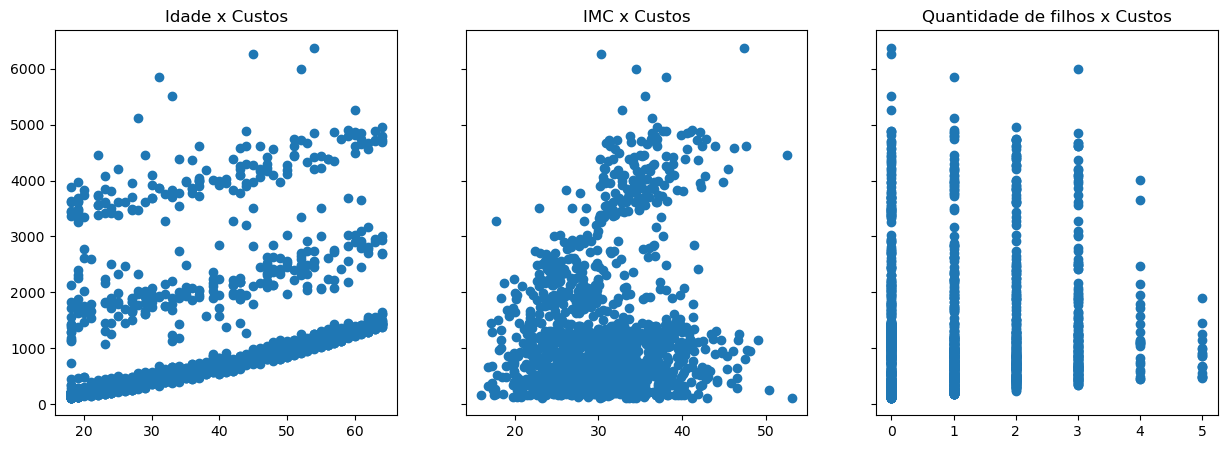

In [41]:
fig, ((ax1,ax2,ax3)) = plt.subplots(1,3,sharey=True,figsize=(15,5))

ax1.scatter(df['Idade'], df['Custo_Saude']);
ax1.set_title('Idade x Custos');

ax2.scatter(df['IMC'], df['Custo_Saude']);
ax2.set_title('IMC x Custos');

ax3.scatter(df['Qte_Filhos'], df['Custo_Saude']);
ax3.set_title('Quantidade de filhos x Custos');


Custo de Saúde tem pouca correlação com as variáveis numéricas IMC e Quantidade de Filhos. Talvez as variáveis qualitativas podem ter mais influência nos custo de Saúde. Veremos ao rodar o modelo. A variável idade sugere uma correlação. **Fora que podem existir grupos distintos de maior custos devido ao formato da Dispersão.**

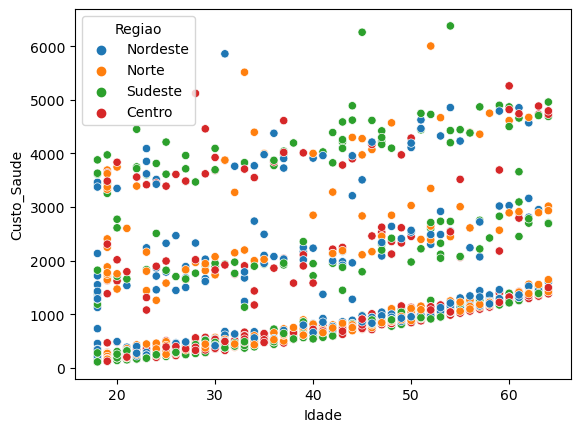

In [42]:
sns.scatterplot(df['Idade'], df['Custo_Saude'], hue = df['Regiao']);

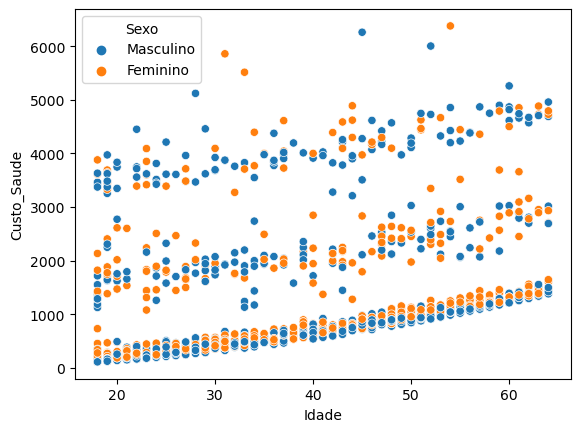

In [43]:
sns.scatterplot(df['Idade'], df['Custo_Saude'], hue = df['Sexo']);

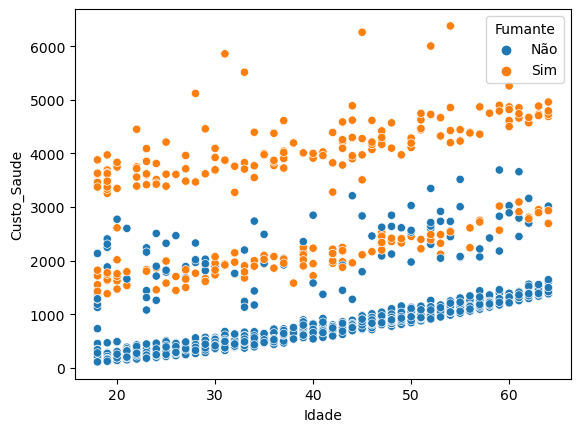

In [44]:
sns.scatterplot(df['Idade'], df['Custo_Saude'], hue = df['Fumante']);

A variável Fumante parece ter uma relação importante. **Os fumantes tem um custo de saúde muito superior a quem não fuma.**


# 3) Desenvolvimento do modelo

In [45]:
x = df.drop(['DtRef','Custo_Saude'], axis=1)
y = df['Custo_Saude']

x = pd.get_dummies(x, drop_first=True)

##  3.1) Validação Out of Sample

In [47]:
# Particionar a base em 70% para treino e 30% para teste
X_train, X_test, y_train, y_test = train_test_split(x,y,
                                                   test_size = 0.3,
                                                   random_state=50)

In [48]:
modelo = linear_model.LinearRegression(fit_intercept=True)
modelo.fit(X_train, y_train)

LinearRegression()

In [49]:
pd.DataFrame({'Variáveis': X_train.columns, 'Betas':modelo.coef_})

,Variáveis,Betas
0,Idade,24.718403
1,IMC,33.669597
2,Qte_Filhos,58.957392
3,Sexo_Masculino,-26.682137
4,Fumante_Sim,2389.734268
5,Regiao_Nordeste,43.389732
6,Regiao_Norte,51.983317
7,Regiao_Sudeste,-54.283788


In [56]:
# R2 em treino
custo_estimado_train = modelo.predict(X_train)
r2_train = r2_score(y_train, custo_estimado_train)

# R2 em teste
custo_estimado_test = modelo.predict(X_test)
r2_test = r2_score(y_test, custo_estimado_test)

pd.DataFrame({'R2 em Treino': r2_train, 'R2 em Teste': r2_test},[0])

,R2 em Treino,R2 em Teste
0,0.75165,0.74665


## 3.2) Validação Cruzada - K-Fold

In [57]:
particoes = KFold(n_splits = 5, shuffle = True, random_state = 42)

In [59]:
r2_train = []
r2_test = []

for train_index, test_index in particoes.split(x):
    
    # separa a base
    X_train, X_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # treina o modelo
    modelo = linear_model.LinearRegression(fit_intercept = True)
    modelo.fit(X_train, y_train)
    
    # R2 em treino
    custo_estimado_train = modelo.predict(X_train)
    r2_train.append(r2_score(y_train, custo_estimado_train))
    
    # R2 em teste
    custo_estimado_test = modelo.predict(X_test)
    r2_test.append(r2_score(y_test, custo_estimado_test))
    
    
resultado = pd.DataFrame({'R2 em Treino': r2_train, 'R2 em Teste': r2_test})
resultado

,R2 em Treino,R2 em Teste
0,0.752771,0.740228
1,0.750053,0.754157
2,0.757518,0.715936
3,0.743434,0.775681
4,0.753532,0.734160


In [61]:
resultado.describe().loc[['mean','std']]

,R2 em Treino,R2 em Teste
mean,0.751462,0.744032
std,0.005223,0.022392


## 3.3) Validação Out of Time

In [63]:
df['DtRef'].value_counts().sort_index()

202101    105
202102    112
202103    107
202104    122
202105    114
202106    117
202107    101
202108    115
202109    119
202110    102
202111    114
202112    110
Name: DtRef, dtype: int64

In [64]:
# Vamos separar os meses de 202101 a 202108 como treino e o restante como teste

In [66]:
df_dummies = pd.get_dummies(df, drop_first = True)

In [67]:
df_train = df_dummies[df_dummies['DtRef'] <= 202108].copy()
df_test = df_dummies[df_dummies['DtRef'] > 202108].copy()

In [73]:
X_train = df_train.drop(['Custo_Saude', 'DtRef'], axis = 1)
y_train = df_train['Custo_Saude']

X_test = df_test.drop(['Custo_Saude', 'DtRef'], axis = 1)
y_test = df_test['Custo_Saude']

In [70]:
modelo = linear_model.LinearRegression(fit_intercept=True)
modelo.fit(X_train, y_train)

LinearRegression()

In [71]:
pd.DataFrame({'Variáveis': X_train.columns, 'Betas':modelo.coef_})

,Variáveis,Betas
0,Idade,25.142540
1,IMC,31.804968
2,Qte_Filhos,48.894520
3,Sexo_Masculino,-34.764725
4,Fumante_Sim,2282.573503
5,Regiao_Nordeste,94.925033
6,Regiao_Norte,92.486954
7,Regiao_Sudeste,-5.951687


In [74]:
# R2 em treino
custo_estimado_train = modelo.predict(X_train)
r2_train = r2_score(y_train, custo_estimado_train)

# R2 em teste
custo_estimado_test = modelo.predict(X_test)
r2_test = r2_score(y_test, custo_estimado_test)

pd.DataFrame({'R2 em Treino': r2_train, 'R2 em Teste': r2_test},[0])

,R2 em Treino,R2 em Teste
0,0.730722,0.780252


### 3.3.1) Validação Out of Time - Acompanhamento do R2 ao longo do tempo

In [75]:
df_dummies['Custo_Saude_Estimado'] = modelo.predict(df_dummies.drop(['Custo_Saude','DtRef'], axis=1))

In [77]:
r2_por_ano_mes = {}

for anomes in df['DtRef'].unique():
    df_anomes = df_dummies[df_dummies['DtRef'] == anomes]
    r2 = r2_score(df_anomes['Custo_Saude'], df_anomes['Custo_Saude_Estimado'])
    r2_por_ano_mes.update({anomes: r2})
    
    
df_r2_por_ano_mes = pd.DataFrame(r2_por_ano_mes,[0]).T.rename(columns={0: 'R2'})

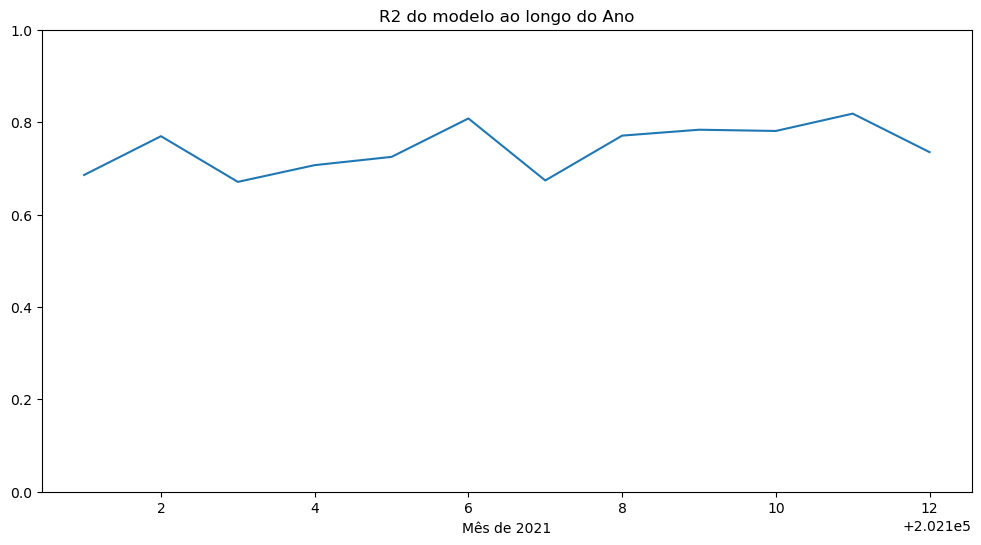

In [79]:
plt.figure(figsize=(12,6))
plt.plot(df_r2_por_ano_mes['R2'])
plt.ylim(bottom=0,top=1)
plt.title("R2 do modelo ao longo do Ano");
plt.xlabel('Mês de 2021');


## 3.4) Afinal, qual a melhor validação para este problema e qual o r2 geral do modelo?

Comparando os resultados de Validação Cruzada e Validação Out of Time:

In [83]:
# Validação Cruzada K-Fold = 5
resultado

,R2 em Treino,R2 em Teste
0,0.752771,0.740228
1,0.750053,0.754157
2,0.757518,0.715936
3,0.743434,0.775681
4,0.753532,0.734160


In [84]:
# Validação Out of Time (treino até 202108 e teste de 202109 a 202112)
pd.DataFrame({'R2 em Treino': r2_train, 'R2 em Teste': r2_test},[0])

,R2 em Treino,R2 em Teste
0,0.730722,0.780252


Todas as validações estão boas, mas como queremos prever o modelo através do tempo a validação Out of Time se torna a mais adequada.